Install requirements:

In [1]:
!pip install pycoingecko

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests, json
import pycoingecko
from pycoingecko import CoinGeckoAPI
import time
from numpy.lib.polynomial import polyint
import datetime
from datetime import timedelta
import plotly.graph_objects as go
from IPython.core.display import display_svg
from numpy import *
cg = CoinGeckoAPI()

1. Get Current Price:

In [ ]:
# crt_price = cg.get_price(ids='bitcoin', vs_currencies='usd', include_24hr_vol=True)

2. Get Historical Price:

In [ ]:
# hst_price = cg.get_coin_history_by_id(id='bitcoin', vs_currencies='usd', date='28-12-2021')

In [3]:
def Hst_Data_Collection_by_day(id, vs_currency, days):
  chart_price = cg.get_coin_market_chart_by_id(id=id, vs_currency=vs_currency, days=days)
  df = pd.DataFrame(chart_price['prices'], columns = ['time_stamp', 'prices'])
  for index, row in df.iterrows():
    df.loc[index, 'date_time'] = str(datetime.datetime.fromtimestamp(row['time_stamp'] / 1000))[:16]
  order = ['date_time', 'time_stamp', 'prices']
  df = df[order]
  df['date_time'] = pd.to_datetime(df['date_time'])
  df.drop(columns=['time_stamp'], inplace=True)

  df1 = df.set_index('date_time')
  update_time = df['date_time'].iloc[-1]
  update_time_mark = str(update_time).replace(" ","")
  update_time_mark = update_time_mark.replace('-', '')
  update_time_mark = update_time_mark.replace(':', '')
  df1.to_csv(f'./price_{id}_{vs_currency}_{days}_{update_time_mark[:-2]}.csv')
  return df1

def time_rounding(df):
  days = (df.tail(1).index - df.head(1).index).days
  days = days[0]
  df_shape = df.shape

  if days <= 1:
    start_time_mark = str(df.index[0])[:16]
    end_time_mark = str(df.index[-1])[:16]
    index_minute = pd.date_range(start=start_time_mark, end=end_time_mark, freq="min")
    df2 = pd.DataFrame(index=index_minute)
    df3 = df2.join(df, how='outer')
    df3 = df3.fillna(method='pad')
    df_out = df3.fillna(method='bfill')

  elif days > 1 and days < 91:
    index_hourly = pd.date_range(start=str(df.index[0])[:13] + '0000', periods=df.shape[0], freq='H')
    if df_shape[1] == 1:
      prices = np.array(df['prices'])
      df_out = pd.DataFrame({'prices': prices}, index=index_hourly)
    elif df_shape[1] == 3:
      prices = np.array(df['prices'])
      market_caps = np.array(df['market_caps'])
      total_volumes = np.array(df['total_volumes'])
      df_out = pd.DataFrame({'prices': prices,
                             'market_caps': market_caps,
                             'total_volumes': total_volumes},
                            index=index_hourly)

  elif days >= 91:
    index_dayly = pd.date_range(start=str(df.index[0])[:13] + '0000', periods=df.shape[0], freq='D')
    prices = np.array(df['prices'])
    df_out = pd.DataFrame({'prices': prices}, index=index_dayly)
    if df_shape[1] == 1:
      prices = np.array(df['prices'])
      df_out = pd.DataFrame({'prices': prices}, index=index_dayly)
    elif df_shape[1] == 3:
      prices = np.array(df['prices'])
      market_caps = np.array(df['market_caps'])
      total_volumes = np.array(df['total_volumes'])
      df_out = pd.DataFrame({'prices': prices,
                             'market_caps': market_caps,
                             'total_volumes': total_volumes},
                            index=index_dayly)
  return df_out

def datetime_timestamp(date_time):
  time.strptime(date_time, '%Y-%m-%d %H:%M:%S')
  s = time.mktime(time.strptime(date_time, '%Y-%m-%d %H:%M:%S'))
  return int(s)

def Hst_Data_Collection_customize(id, vs_currency, start_time, end_time):
  current_timestamp = int(time.time())
  start_stamp = datetime_timestamp(start_time)
  end_stamp = datetime_timestamp(end_time)
  market_chart = cg.get_coin_market_chart_range_by_id(id=id,
                                      vs_currency=vs_currency,
                                      from_timestamp=start_stamp,
                                      to_timestamp=end_stamp)
  market_chart = pd.DataFrame(market_chart)
  price_list = []
  market_caps_list = []
  total_volumes_list = []
  timestamp_list = []
  date_time = []
  for index, row in market_chart.iterrows():
    timestamp_list.append(market_chart['prices'].iloc[index][0])
    date_time.append(str(datetime.datetime.fromtimestamp(market_chart['prices'].iloc[index][0] / 1000))[:16])
    price_list.append(market_chart['prices'].iloc[index][1])
    market_caps_list.append(market_chart['market_caps'].iloc[index][1])
    total_volumes_list.append(market_chart['total_volumes'].iloc[index][1])
    
  df_new = pd.DataFrame({'prices': price_list,
                        'market_caps': market_caps_list,
                        'total_volumes': total_volumes_list,
                        'date_time': date_time}, index=date_time)
  df_new['date_time'] = pd.to_datetime(df_new['date_time'])
  df = df_new.set_index('date_time')

  return df



**3. Time Rounding:**

Collect Historical Data, round irregular timestamps and save it as CSV.
id, vs_currency and days are indispensable parameters.
If days <= 1, the time granularity of the data will become minute-level. If  1 < days < 90, the granularity will become hourly. The time granularity  will become day-level if the time span you specify is greater than 120. 

In [4]:
id = 'bitcoin'
vs_currency = 'usd'
# days = 30
now = str(datetime.datetime.fromtimestamp(int(time.time())))
print(now)

# hst_data2 = Hst_Data_Collection_by_day(id, vs_currency, days)

start_time = '2022-01-01 00:00:00'
end_time = '2022-09-16 00:00:00'

hst_data2 = Hst_Data_Collection_customize(id, vs_currency, start_time, end_time)
# print(hst_data2)

time_rounding_df = time_rounding(hst_data2)
print(time_rounding_df)
time_rounding_df.to_csv('./test_data.csv')
# print(hst_data2)
# print(time_rounding_df)
# time_rounding_df.plot(y = 'prices')
# time_rounding_df.plot(y = 'market_caps')
# time_rounding_df.plot(y = 'total_volumes')


2022-10-14 12:56:44
                  prices   market_caps  total_volumes
2022-01-01  46319.651088  8.761929e+11   2.589535e+10
2022-01-02  47816.077676  9.045519e+11   1.890459e+10
2022-01-03  47387.212168  8.975361e+11   3.375613e+10
2022-01-04  46531.140861  8.803302e+11   2.189002e+10
2022-01-05  45938.024272  8.762427e+11   2.489599e+10
...                  ...           ...            ...
2022-09-12  21739.804380  4.160736e+11   3.126625e+10
2022-09-13  22339.670503  4.274738e+11   4.400649e+10
2022-09-14  20184.967492  3.865297e+11   4.648989e+10
2022-09-15  20255.922978  3.874862e+11   3.578902e+10
2022-09-16  19702.169890  3.777194e+11   3.371596e+10

[259 rows x 3 columns]


5. Drawing Charts：

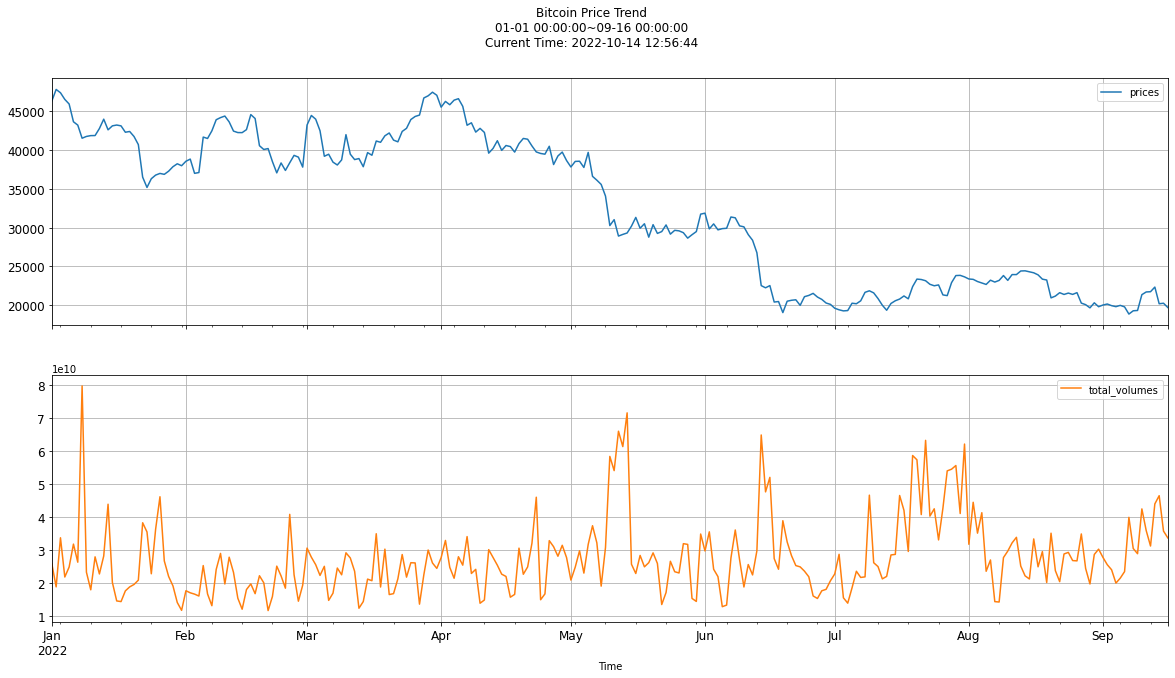

In [5]:
title = str.title(id)
start = str(time_rounding_df.index[0])
end = str(time_rounding_df.index[-1])

time_rounding_df[['prices', 'total_volumes']].plot(subplots=True,
                                                   figsize=(20, 10),
                                                   title=f'{title} Price Trend\n{start[5:19]}~{end[5:19]}\nCurrent Time: {now}',
                                                   grid=True,
                                                   xlabel='Time',
                                                   fontsize=12,
                                                   sharex=True)

plt.show()



**Historical Data Replay**

In [ ]:
replay_data = pd.read_csv('./test_data.csv', index_col=0)
# print(replay_data)
start_date_time = pd.to_datetime(replay_data.index[0])
# print(start_date_time)
Time_Now = start_date_time
for i in range(500):
  Time_Now = Time_Now + pd.Timedelta(15, unit='min')
  
  print(Time_Now)
  i = i + 1


2022-01-01 00:15:00
2022-01-01 00:30:00
2022-01-01 00:45:00
2022-01-01 01:00:00
2022-01-01 01:15:00
2022-01-01 01:30:00
2022-01-01 01:45:00
2022-01-01 02:00:00
2022-01-01 02:15:00
2022-01-01 02:30:00
2022-01-01 02:45:00
2022-01-01 03:00:00
2022-01-01 03:15:00
2022-01-01 03:30:00
2022-01-01 03:45:00
2022-01-01 04:00:00
2022-01-01 04:15:00
2022-01-01 04:30:00
2022-01-01 04:45:00
2022-01-01 05:00:00
2022-01-01 05:15:00
2022-01-01 05:30:00
2022-01-01 05:45:00
2022-01-01 06:00:00
2022-01-01 06:15:00
2022-01-01 06:30:00
2022-01-01 06:45:00
2022-01-01 07:00:00
2022-01-01 07:15:00
2022-01-01 07:30:00
2022-01-01 07:45:00
2022-01-01 08:00:00
2022-01-01 08:15:00
2022-01-01 08:30:00
2022-01-01 08:45:00
2022-01-01 09:00:00
2022-01-01 09:15:00
2022-01-01 09:30:00
2022-01-01 09:45:00
2022-01-01 10:00:00
2022-01-01 10:15:00
2022-01-01 10:30:00
2022-01-01 10:45:00
2022-01-01 11:00:00
2022-01-01 11:15:00
2022-01-01 11:30:00
2022-01-01 11:45:00
2022-01-01 12:00:00
2022-01-01 12:15:00
2022-01-01 12:30:00
